In [96]:
!pip3 install torch torchvision

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [99]:
transform_train = transforms.Compose([transforms.Resize((32, 32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))
                                      ])

transform = transforms.Compose([transforms.Resize((32, 32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])

training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [0]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

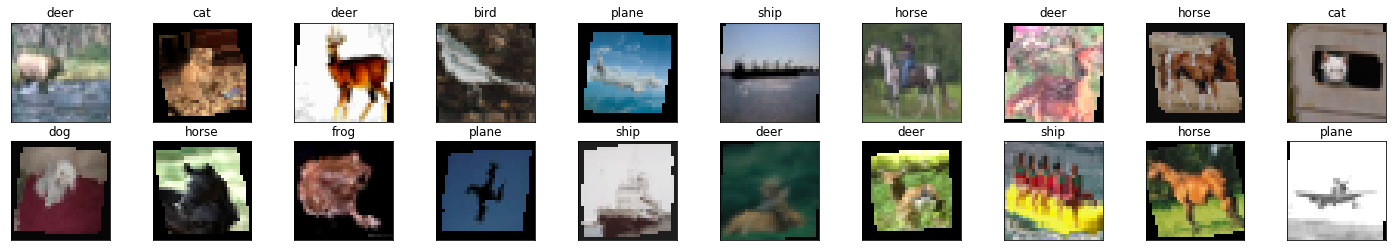

In [102]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [0]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
    self.fc1 = nn.Linear(1024, 500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10)
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 1024)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x

In [104]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [106]:
epochs = 15

running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)

        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
    
    epoch_loss = running_loss/len(training_loader)
    epoch_accuracy = running_corrects.float()/len(training_loader)
    
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_accuracy)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_accuracy = val_running_corrects.float()/len(validation_loader)
    
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_accuracy)
    print('epoch:', e)
    print('Training Loss: {:.4f}, Training Accuracy: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}'.format(epoch_loss, epoch_accuracy.item(), val_epoch_loss, val_epoch_accuracy.item()))

epoch: 0
Training Loss: 1.7136, Training Accuracy: 37.0400, Validation Loss: 1.4184, Validation Accuracy: 47.4200
epoch: 1
Training Loss: 1.3910, Training Accuracy: 49.6720, Validation Loss: 1.2102, Validation Accuracy: 56.8200
epoch: 2
Training Loss: 1.2521, Training Accuracy: 55.2540, Validation Loss: 1.0902, Validation Accuracy: 61.2500
epoch: 3
Training Loss: 1.1662, Training Accuracy: 58.5220, Validation Loss: 1.0283, Validation Accuracy: 64.1400
epoch: 4
Training Loss: 1.1027, Training Accuracy: 60.9200, Validation Loss: 0.9995, Validation Accuracy: 64.8300
epoch: 5
Training Loss: 1.0445, Training Accuracy: 63.1860, Validation Loss: 0.9432, Validation Accuracy: 66.5700
epoch: 6
Training Loss: 1.0036, Training Accuracy: 64.5420, Validation Loss: 0.8945, Validation Accuracy: 68.4400
epoch: 7
Training Loss: 0.9757, Training Accuracy: 65.4360, Validation Loss: 0.9374, Validation Accuracy: 67.2300
epoch: 8
Training Loss: 0.9527, Training Accuracy: 66.4460, Validation Loss: 0.8599, Val

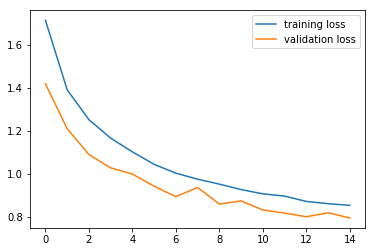

In [107]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

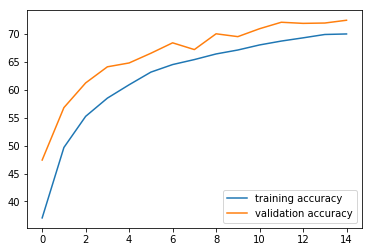

In [108]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [0]:
# !pip3 install pillow==4.0.0

<Response [200]>


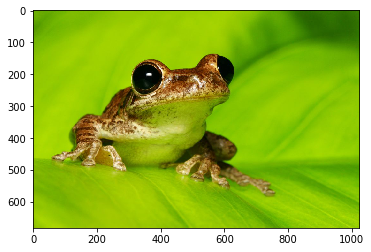

In [110]:
import requests
from PIL import Image
import PIL.ImageOps
url = 'https://uconn-today-universityofconn.netdna-ssl.com/wp-content/uploads/2017/07/GettyImages-146798910-CubanTreeFrog-1024x683.jpg'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)
print(response)

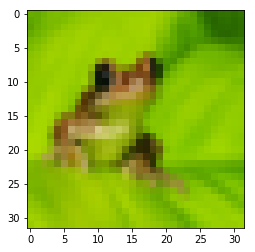

In [111]:
img = transform(img)
plt.imshow(im_convert(img))

In [112]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

frog


<Response [200]>


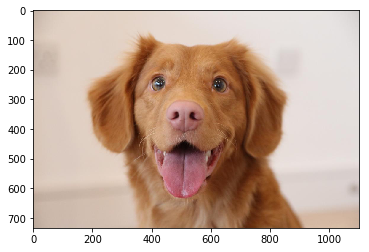

In [120]:
import requests
from PIL import Image
import PIL.ImageOps
url = 'https://cdn1.medicalnewstoday.com/content/images/articles/322/322868/golden-retriever-puppy.jpg'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)
print(response)

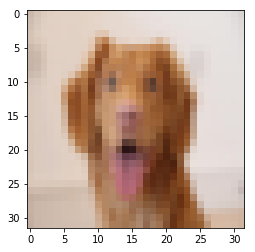

In [121]:
img = transform(img)
plt.imshow(im_convert(img))

In [122]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

dog


<Response [200]>


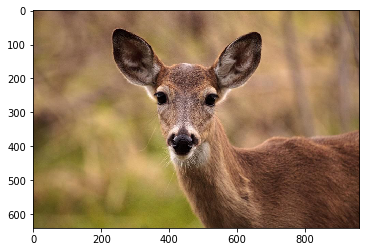

In [124]:
import requests
from PIL import Image
import PIL.ImageOps
url = 'https://thumbor.forbes.com/thumbor/960x0/https%3A%2F%2Fspecials-images.forbesimg.com%2Fdam%2Fimageserve%2F1007655361%2F960x0.jpg%3Ffit%3Dscale'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)
print(response)

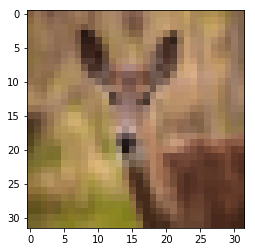

In [125]:
img = transform(img)
plt.imshow(im_convert(img))

In [126]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

deer


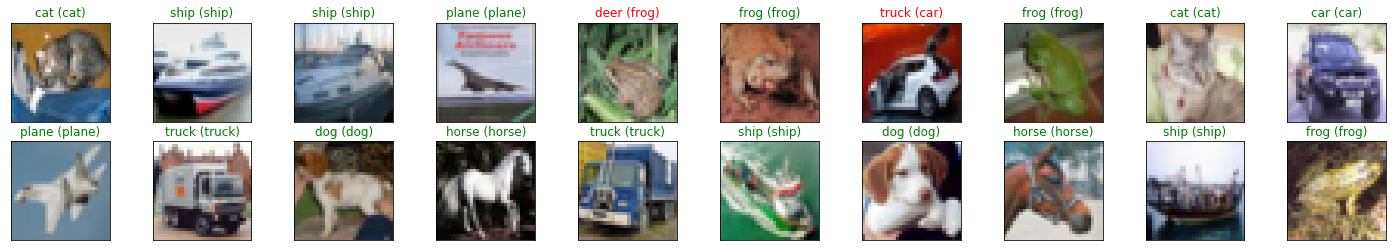

In [127]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)
 
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(classes[preds[idx].item()], classes[labels[idx].item()]), color=("green" if preds[idx]==labels[idx] else "red"))